<a href="https://colab.research.google.com/github/jickysid/Projects/blob/master/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
re
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
#%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# parameters
im_width = 224
im_height = 224
border = 5


In [0]:
im_width1 = 128
im_height1 = 128
border = 5

In [0]:
masks = os.listdir('/content/gdrive/My Drive/Colab Notebooks/masks')
images = os.listdir('/content/gdrive/My Drive/Colab Notebooks/images')

In [0]:
def file_read(fname):
        content_array = []
        with open(fname) as f:
                #Content_list is the list that contains the read lines.     
                
                for line in f:
                        if line.endswith('\n'):
                            line = line[:-2]
                            content_array.append(line + ".jpg")
                        
                print(content_array)
        return content_array


ids = file_read('trainval.txt')


In [0]:
# LOADING TRAINING DATA
ids = os.listdir('/content/gdrive/My Drive/Colab Notebooks/images') # list of names all images in the given path
#print("No. of images = ", len(ids))

X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
X1 = np.zeros((len(ids), im_height1, im_width1, 1), dtype=np.float32)
y1 = np.zeros((len(ids), im_height1, im_width1, 1), dtype=np.float32)

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/gdrive/My Drive/Colab Notebooks/images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img1 = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    x_img = resize(x_img, (224, 224, 1), mode = 'constant', preserve_range = True)
    
    # Load masks
    mask = img_to_array(load_img("/content/gdrive/My Drive/Colab Notebooks/masks/"+id_, grayscale=True))
    mask1 = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    mask = resize(mask, (224, 224, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0
    X1[n] = x_img1/255.0
    y1[n] = mask1/255.0

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(X1, y1, test_size=0.1, random_state=42)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
print (len(X), len(X1))

4000 4000


Text(0.5, 1.0, 'Salt')

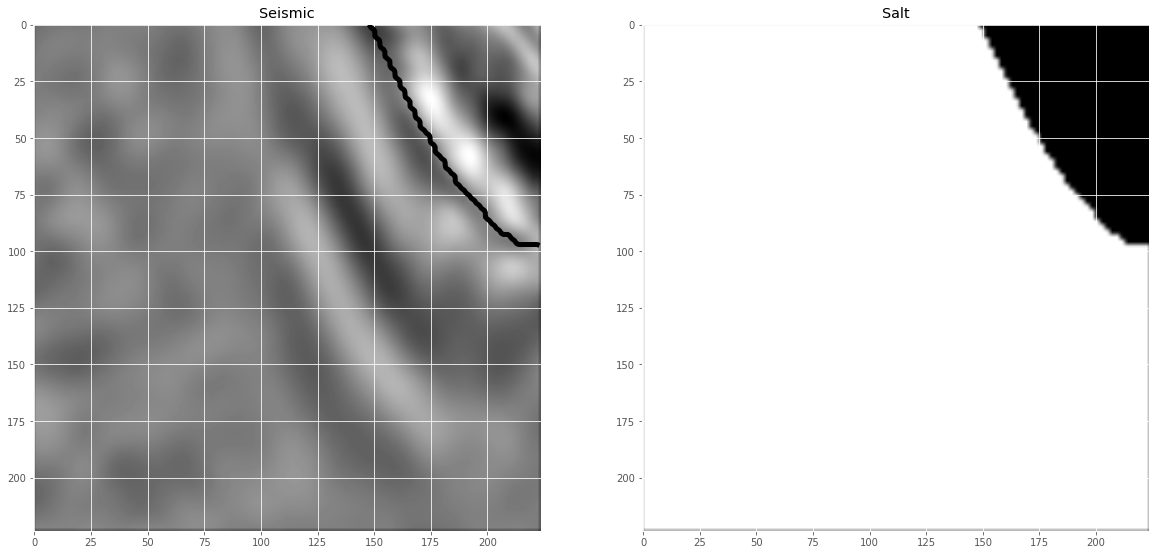

In [0]:
#Visualisation of training data images and mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')


In [0]:
#Function to add 2 convolutional layers with the parameters passed to it
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


In [0]:
def conv2d_block1(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # third layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


In [0]:
def get_vgg16(input_img, n_filters = 64, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
  
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    
    
    c3 = conv2d_block1(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = conv2d_block1(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = conv2d_block1(p4, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p5 = MaxPooling2D((2, 2))(c5)
    
    # FCN converted to CNN
    c0 = Conv2D(1, (1,1), activation = 'relu')(p5)
#    c0 = Conv2D(4096, (1, 1), activation = 'relu')(p5)
#    c0 = Conv2D(1000, (1, 1), activation = 'relu')(c0)
#    c0 = Conv2DTranspose(4096, (1, 1))(c0)
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c0)
    u6 = concatenate([u6, c5])
    c6 = conv2d_block1(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c4])
    c7 = conv2d_block1(u7, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c3])
    c8 = conv2d_block1(u8, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c2])
    c9 = conv2d_block(u9, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u10 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c9)
    u10 = concatenate([u10, c1])
    c10 = conv2d_block(u10, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c10)
    modelVGG = Model(inputs=[input_img], outputs=[outputs])
    return modelVGG



input_img = Input((im_height, im_width, 1), name='img')
modelVGG = get_vgg16(input_img, n_filters=64, dropout=0.05, batchnorm=True)
modelVGG.compile(optimizer=Adam(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"])

modelVGG.summary()


W0708 17:43:11.992198 140476235179904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 17:43:12.039255 140476235179904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 17:43:12.041054 140476235179904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0708 17:43:12.084229 140476235179904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0708 17:43:12.085074

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 64) 640         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 224, 224, 64) 256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 224, 224, 64) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin

In [0]:
#UNET
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    modelUNET = Model(inputs=[input_img], outputs=[outputs])
    return modelUNET


#print(keras.optimizers.Adam())
input_img1 = Input((im_height1, im_width1, 1), name='img1')
modelUNET = get_unet(input_img1, n_filters=16, dropout=0.05, batchnorm=True)
modelUNET.compile(optimizer=Adam(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"])
modelUNET.summary()

W0708 17:43:28.238858 140476235179904 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img1 (InputLayer)               (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 128, 128, 16) 160         img1[0][0]                       
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 128, 128, 16) 64          conv2d_30[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 128, 128, 16) 0           batch_normalization_28[0][0]     
__________________________________________________________________________________________________
max_poolin

In [0]:
#stop earlier even if epochs are not completed but purpose is served(VGG16)
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/model-tgs-salt-VGG16-50-1.h5', verbose=1, save_best_only=True)
]

results = modelVGG.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))



Train on 3600 samples, validate on 400 samples
Epoch 1/50
3600/3600 [==============================] - 112s 31ms/step - loss: 0.2020 - acc: 0.9143 - val_loss: 0.3156 - val_acc: 0.8662

Epoch 00001: val_loss improved from inf to 0.31558, saving model to /content/gdrive/My Drive/Colab Notebooks/model-tgs-salt-VGG16-50-1.h5
Epoch 2/50
3600/3600 [==============================] - 112s 31ms/step - loss: 0.1992 - acc: 0.9155 - val_loss: 0.2474 - val_acc: 0.8952

Epoch 00002: val_loss improved from 0.31558 to 0.24737, saving model to /content/gdrive/My Drive/Colab Notebooks/model-tgs-salt-VGG16-50-1.h5
Epoch 3/50
3600/3600 [==============================] - 112s 31ms/step - loss: 0.1942 - acc: 0.9167 - val_loss: 0.4778 - val_acc: 0.8289

Epoch 00003: val_loss did not improve from 0.24737
Epoch 4/50
3600/3600 [==============================] - 112s 31ms/step - loss: 0.1930 - acc: 0.9176 - val_loss: 0.2819 - val_acc: 0.8705

Epoch 00004: val_loss did not improve from 0.24737
Epoch 5/50
3600/360

In [0]:
#stop earlier even if epochs are not completed but purpose is served(VGG16)
callbacks1 = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('model-tgs-salt-UNET-50.h5', verbose=1, save_best_only=True)
]

results1 = modelUNET.fit(X_train1, y_train1, batch_size=32, epochs=50, callbacks=callbacks1,\
                    validation_data=(X_valid1, y_valid1))


Train on 3600 samples, validate on 400 samples
Epoch 1/50
3600/3600 [==============================] - 9s 3ms/step - loss: 0.1978 - acc: 0.9133 - val_loss: 0.3799 - val_acc: 0.8573

Epoch 00001: val_loss improved from inf to 0.37992, saving model to model-tgs-salt-UNET-50.h5
Epoch 2/50
3600/3600 [==============================] - 9s 3ms/step - loss: 0.1882 - acc: 0.9167 - val_loss: 0.2199 - val_acc: 0.9098

Epoch 00002: val_loss improved from 0.37992 to 0.21995, saving model to model-tgs-salt-UNET-50.h5
Epoch 3/50
3600/3600 [==============================] - 9s 3ms/step - loss: 0.1830 - acc: 0.9187 - val_loss: 0.2934 - val_acc: 0.8692

Epoch 00003: val_loss did not improve from 0.21995
Epoch 4/50
3600/3600 [==============================] - 9s 3ms/step - loss: 0.1754 - acc: 0.9227 - val_loss: 0.3302 - val_acc: 0.8706

Epoch 00004: val_loss did not improve from 0.21995
Epoch 5/50
3600/3600 [==============================] - 9s 2ms/step - loss: 0.1732 - acc: 0.9228 - val_loss: 0.2787 - v

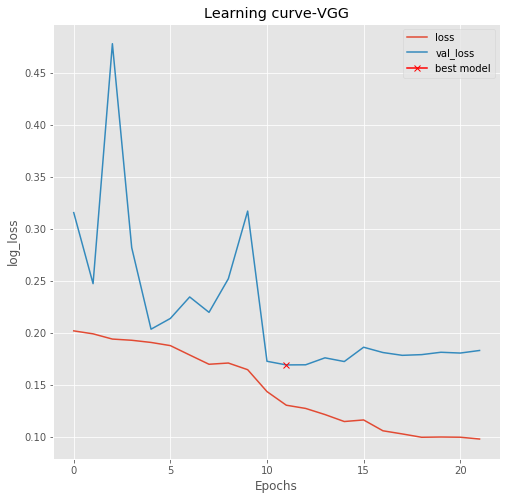

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve-VGG")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


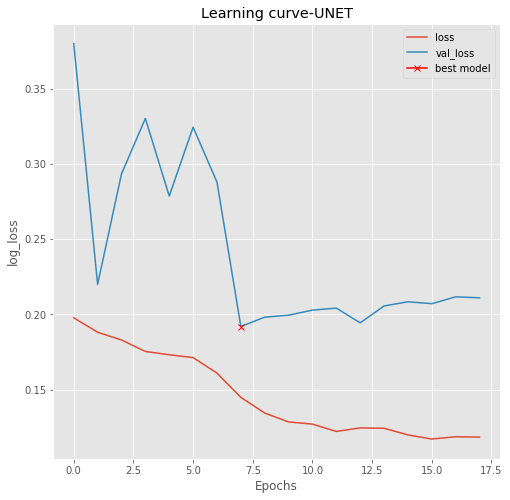

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve-UNET")
plt.plot(results1.history["loss"], label="loss")
plt.plot(results1.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results1.history["val_loss"]), np.min(results1.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


In [0]:
modelUNET = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/model-tgs-salt-UNET.h5')

In [0]:
# LOADING TESTING DATA
ids = os.listdir('/content/gdrive/My Drive/Colab Notebooks/testing_images') # list of names all images in the given path
#print("No. of images = ", len(ids))

X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/gdrive/My Drive/Colab Notebooks/testing_images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (224, 224, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0

X_test = X


FileNotFoundError: ignored

In [0]:
t = 0.6
# Predict on train, val and test
preds_train = modelVGG.predict(X_train, verbose=1)
preds_val = modelVGG.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > t).astype(np.uint8)
preds_val_t = (preds_val > t).astype(np.uint8)



400/400 [==============================] - 4s 10ms/step


In [0]:
p = 0.6
# Predict on train, val and test
preds_train1 = modelUNET.predict(X_train1, verbose=1)
preds_val1 = modelUNET.predict(X_valid1, verbose=1)

# Threshold predictions
preds_train_t1 = (preds_train1 > p).astype(np.uint8)
preds_val_t1 = (preds_val1 > p).astype(np.uint8)

400/400 [==============================] - 0s 637us/step


In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

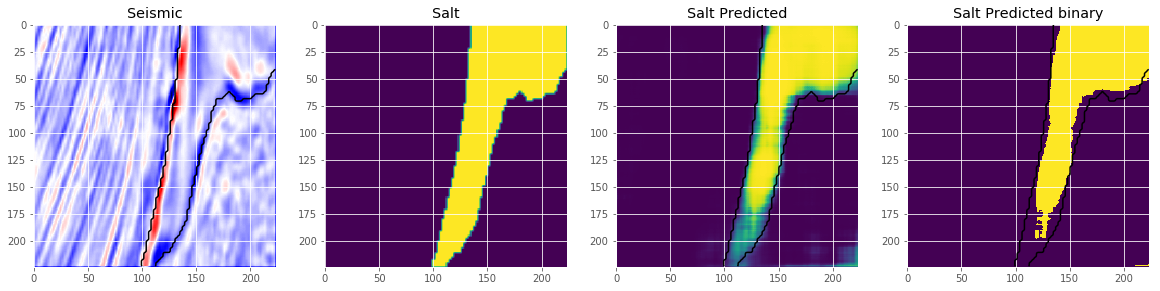

In [0]:
plot_sample(X_train, y_train, preds_train, preds_train_t)


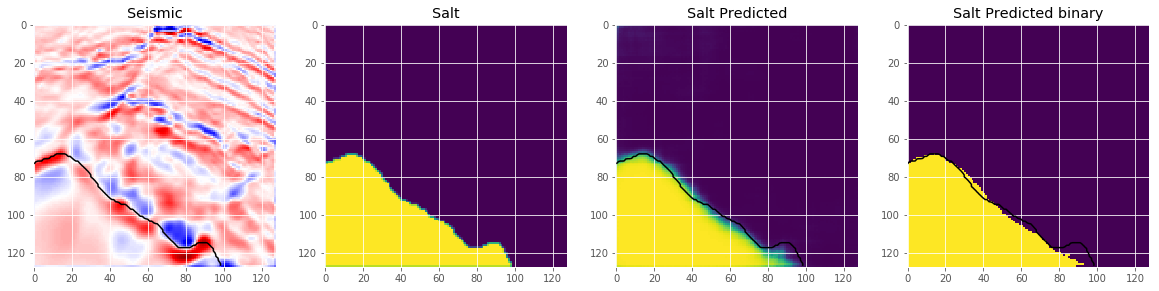

In [0]:
plot_sample(X_train1, y_train1, preds_train1, preds_train_t1)

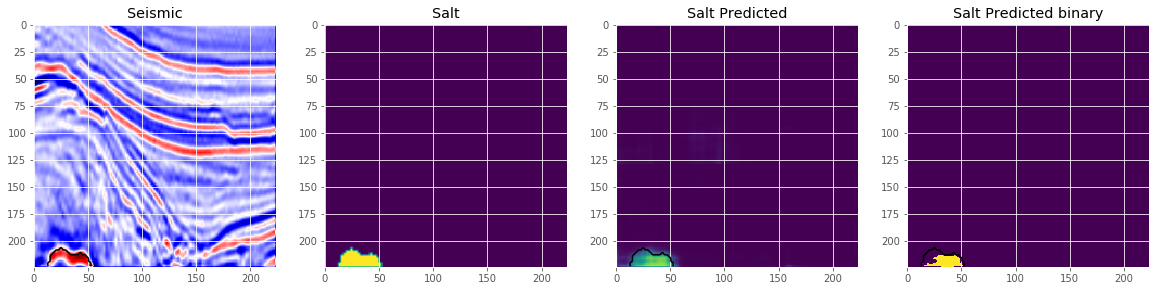

In [0]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

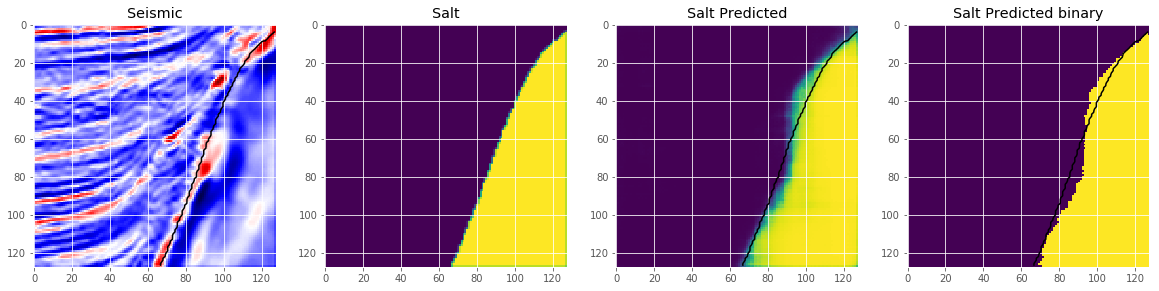

In [0]:
plot_sample(X_valid1, y_valid1, preds_val1, preds_val_t1)